# BindCraft Failure Trajectory Analysis Notebook

This notebook provides a step‑by‑step workflow to analyse 20 failed binder designs produced by the BindCraft pipeline.
It extracts structural and scoring features from each design, searches for common failure patterns, and visualises which
regions of the receptor are most frequently targeted by the failed binders.

**Workflow outline**
1. Environment & data locations
2. Helper utilities (PDB parsing, interface detection, clash scoring)
3. Bulk feature extraction → `design_df`
4. Exploratory data analysis (EDA)
5. Epitope heat‑map & overlap statistics
6. Metric comparison across failure labels
7. Hypothesis checks & redesign recommendations

> **NOTE:** Fill in the `TODO:` sections for project‑specific parameters (folder paths, chain IDs, etc.).


## 0. Dependencies & Environment
Ensure you have the required Python packages.  If running in the original BindCraft Colab notebook, most of these are
already installed.
```bash
!pip install biopython freesasa pandas numpy matplotlib seaborn scikit-learn tqdm
```

In [1]:
import os, glob, json, math, warnings
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from Bio.PDB import (
    PDBParser,
    NeighborSearch,
    is_aa,
    PDBIO,        # <-- added so we can instantiate directly
)
# Freesasa is optional; comment out if unavailable
# try:
#     import freesasa
# except ImportError:
#     freesasa = None

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.dpi": 120})

## 1. Data locations & basic metadata
Define the directory that contains the 20 PDB files and a CSV/JSON file describing their failure labels.

In [2]:
BASE_DIR  = Path("./data/failed_designs")
TRAJ_JSON = Path("./data/protein_design_trajectories.json")
LABEL_MAP: dict[str, str] = {}

pdb_paths = list(BASE_DIR.glob("*/*.pdb"))
print(f"Found {len(pdb_paths)} PDBs across {len(set(p.parent.name for p in pdb_paths))} labels")

Found 20 PDBs across 3 labels


## 2. Helper functions
 ‑ `get_interface_residues`  — returns residue IDs that form contacts across chains

 ‑ `calc_interface_centroid` — geometric centre of interface residues on the receptor

 ‑ `calc_clashscore`         — crude number of heavy‑atom overlaps < 2.0 Å

In [3]:
parser = PDBParser(QUIET=True)

RECEPTOR_CHAINS = {'A'}  
BINDER_CHAINS   = {'B'}  


def _atoms(struct, chains, hetero=False):
    return [atom for model in struct for chain in model if chain.id in chains for res in chain
            if is_aa(res, standard=True) or hetero for atom in res]

def get_interface_residues(struct, cutoff=5.0):
    rec_atoms = _atoms(struct, RECEPTOR_CHAINS)
    bin_atoms = _atoms(struct, BINDER_CHAINS)
    ns = NeighborSearch(rec_atoms + bin_atoms)
    iface_rec, iface_bin = set(), set()
    for atom in rec_atoms:
        for nb in ns.search(atom.coord, cutoff, level='A'):
            if nb in bin_atoms:
                iface_rec.add(atom.get_parent())
                iface_bin.add(nb.get_parent())
    return iface_rec, iface_bin

def centroid(residues):
    coords = np.array([atom.coord for res in residues for atom in res if atom.element != 'H'])
    return coords.mean(axis=0) if coords.size else np.zeros(3)

def clashscore(struct, cutoff=2.0):
    rec_atoms = [a for a in _atoms(struct, RECEPTOR_CHAINS) if a.element != 'H']
    bin_atoms = [a for a in _atoms(struct, BINDER_CHAINS) if a.element != 'H']
    ns = NeighborSearch(rec_atoms)
    return sum(1 for atom in bin_atoms for n in ns.search(atom.coord, cutoff, level='A') if n in rec_atoms)


## 3. Load trajectory‑level metrics (robust to missing / empty entries)

In [4]:
def load_metrics(path: Path):
    if not path.exists():
        warnings.warn("Trajectory JSON not found; metrics skipped")
        return {}
    data = json.load(open(path))
    best = {}
    for t in data.get('trajectories', []):
        stages = t.get('stages', [])
        if not stages: continue
        entries = stages[-1].get('entries', [])
        entries = [e for e in entries if isinstance(e.get('loss'), (int,float))]
        if entries:
            best[t['name']] = min(entries, key=lambda x:x['loss'])
    return best

traj_metrics = load_metrics(TRAJ_JSON)
print('Loaded', len(traj_metrics), 'trajectory metrics')


Loaded 8 trajectory metrics


## 4. Bulk feature extraction loop

In [5]:
iface_cache   = {} 
records = []

for pdb in tqdm(pdb_paths, desc='Extracting'):
    struct = parser.get_structure(pdb.stem, pdb)

    # ① 仅保留重原子，加速 KD-tree
    rec_atoms = [a for a in _atoms(struct, RECEPTOR_CHAINS) if a.element != 'H']
    bin_atoms = [a for a in _atoms(struct, BINDER_CHAINS)   if a.element != 'H']

    # ② 单次 KD-tree 复用
    ns = NeighborSearch(rec_atoms + bin_atoms)

    # ③ 同一次遍历算接口 & 碰撞
    iface_rec = {a.get_parent() for a in rec_atoms
                 for nb in ns.search(a.coord, 5.0, level='A')
                 if nb in bin_atoms}

    clashs = sum(1 for a in bin_atoms
                   for nb in ns.search(a.coord, 2.0, level='A')
                   if nb in rec_atoms)

    # ④ 缓存供热点统计复用
    iface_cache[pdb] = (iface_rec, clashs)

    # ⑤ 记录入表
    cx, cy, cz = centroid(iface_rec)
    records.append({
        'design'          : pdb.stem,
        'failure_label'   : LABEL_MAP.get(pdb.stem, pdb.parent.name),
        'iface_size'      : len(iface_rec),
        'iface_centroid_x': cx,
        'iface_centroid_y': cy,
        'iface_centroid_z': cz,
        'clashscore'      : clashs,
        **traj_metrics.get(pdb.stem, {}),   # if possible
    })

design_df = pd.DataFrame(records)
design_df.to_csv('binder_failure_summary.csv', index=False)
print('CSV saved with', len(design_df), 'rows')

Extracting: 100%|██████████| 20/20 [10:31<00:00, 31.59s/it]

CSV saved with 20 rows


## 5. Exploratory Data Analysis [Not useful]

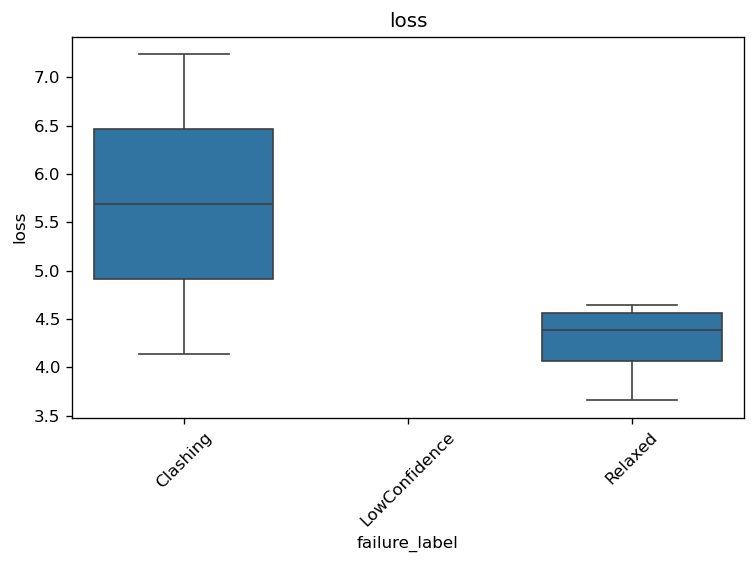

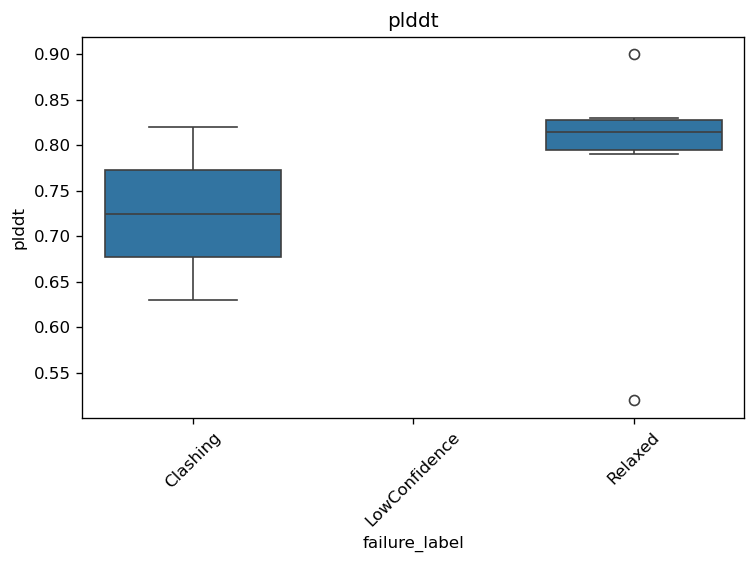

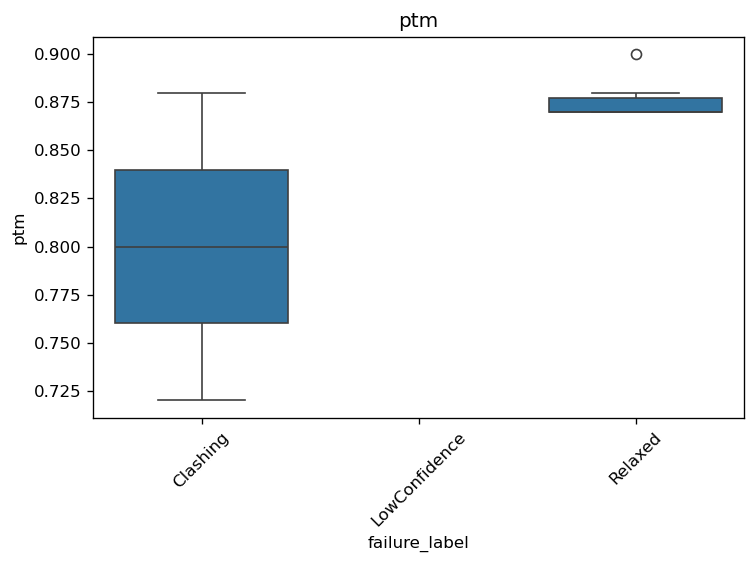

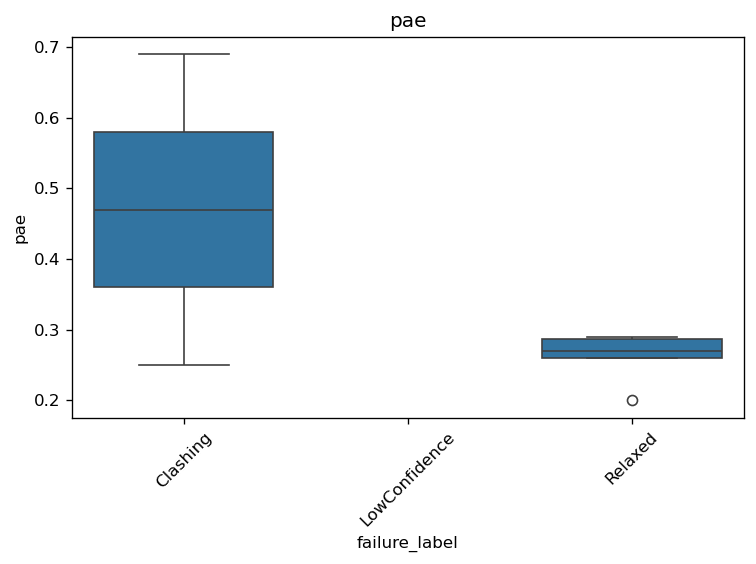

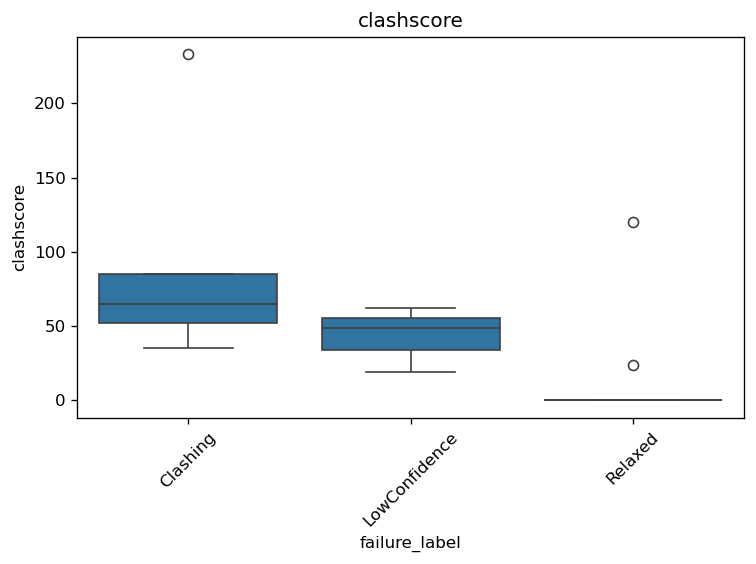

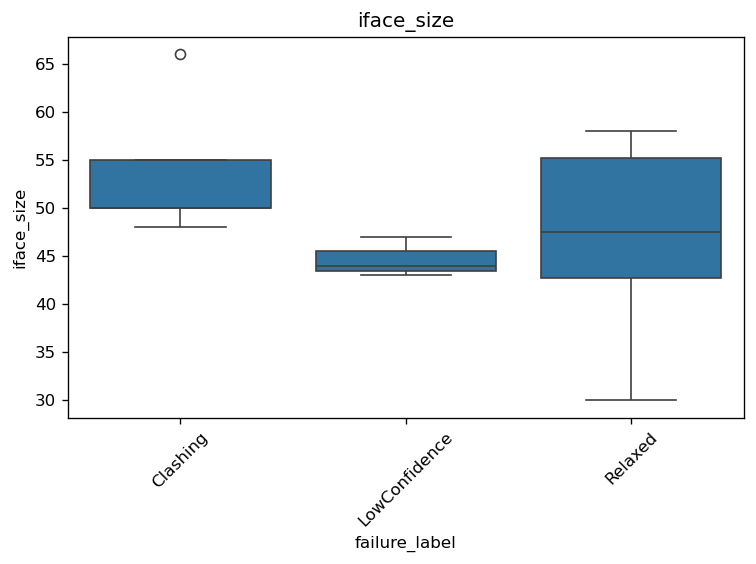

In [6]:
metric_cols = [c for c in ['loss','plddt','ptm','pae','clashscore','iface_size'] if c in design_df.columns]
for m in metric_cols:
    plt.figure(); sns.boxplot(data=design_df, x='failure_label', y=m)
    plt.title(m); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


## 6. Epitope hotspot mapping

In [10]:
freq = Counter()
ref_struct = parser.get_structure('ref', pdb_paths[0])

for pdb in pdb_paths:
    struct = parser.get_structure('tmp', pdb)

    # 仅重原子
    rec_atoms = [a for a in _atoms(struct, RECEPTOR_CHAINS) if a.element != 'H']
    bin_atoms = [a for a in _atoms(struct, BINDER_CHAINS)   if a.element != 'H']

    ns = NeighborSearch(rec_atoms + bin_atoms)
    iface_rec = {a.get_parent()
                 for a in rec_atoms
                 for nb in ns.search(a.coord, 5.0, level='A')
                 if nb in bin_atoms}

    for res in iface_rec:
        freq[(res.get_parent().id, res.id[1], res.resname)] += 1


for model in ref_struct:
    for chain in model:
        for res in chain:
            for atom in res:
                atom.bfactor = freq.get((chain.id, res.id[1], res.resname), 0)

io = PDBIO(); io.set_structure(ref_struct); io.save('receptor_hotspots.pdb')
print('Hotspot PDB exported → receptor_hotspots.pdb')

KeyboardInterrupt: 

## 7. Interface centroid clustering (DBSCAN) [Not useful]

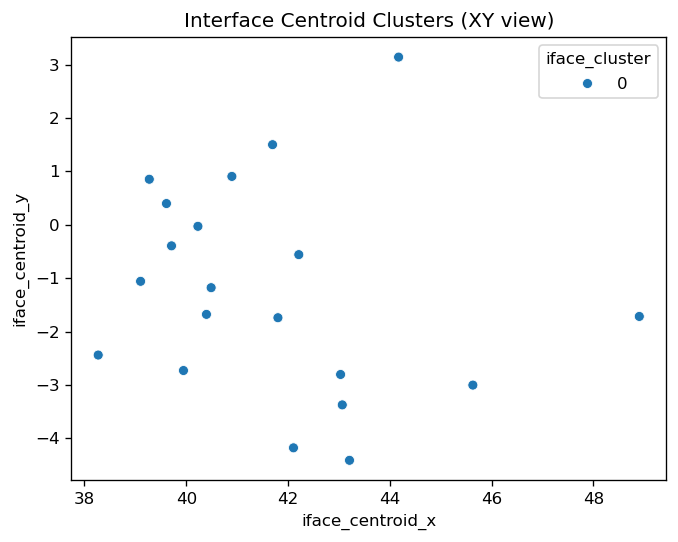

In [8]:
from sklearn.cluster import DBSCAN
centroid_cols = [c for c in design_df.columns if c.startswith('iface_centroid_')]
if centroid_cols:
    db = DBSCAN(eps=5.0, min_samples=2).fit(design_df[centroid_cols])
    design_df['iface_cluster'] = db.labels_
    sns.scatterplot(data=design_df, x='iface_centroid_x', y='iface_centroid_y', hue='iface_cluster')
    plt.title('Interface Centroid Clusters (XY view)')
    plt.show()